In [2]:
import matplotlib.pyplot as plt
from skest import *
import scipy
import time
from signals import *
import numpy as np

### different noise level

In [3]:
n = 80
p = 121
a = 11
D = grid_incidence(a)
G = nx.grid_graph(dim = (a,a))
Psi = cor_from_G(G, 0.5)

In [4]:
from matplotlib.ticker import AutoMinorLocator, MultipleLocator

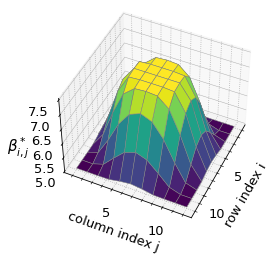

In [5]:
beta_star = smooth_2d(a,2, 3.5, 2.5, 5)
xs = np.linspace(1, a+1, a)
ys = np.linspace(1, a+1, a)
xs, ys = np.meshgrid(xs, ys)
zs_surface = beta_star.reshape(a,a)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xs, ys, zs_surface, rstride=1, cstride=1, cmap='viridis', edgecolor = 'gray', linewidth = 0.5)

ax.view_init(45, 25)

ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_major_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))

ax.xaxis._axinfo["grid"]['linestyle'] = ":"
ax.yaxis._axinfo["grid"]['linestyle'] = ":"
ax.zaxis._axinfo["grid"]['linewidth'] = 0.5

ax.tick_params(axis = 'both', which = 'major', labelsize = 13)
ax.set_ylabel('column index j', size = 13)
ax.set_xlabel('row index i', size = 13)
ax.zaxis.set_rotate_label(False)
ax.set_zlabel(r'$\beta_{i,j}^*$', rotation = 0, size = 15)
plt.savefig('144c.jpg', bbox_inches='tight', dpi = 600)

In [6]:
beta_star = beta_star.flatten()

## require finer grid for GTV oracle

In [8]:
gridGTVsmall = {'l1': [0, 0.005, 0.025, 0.05, 0.1, 0.25, 0.5, 1, 2.5, 5, 7.5], 
           'l2': [0, 0.005, 0.025, 0.05, 0.1, 0.25, 0.5, 1, 2.5, 5, 7.5],
          'l3': [0]} 

def naive_cv_gtv_small(X,y, D = 0, n_cv = 5):
    gd_sr = GridSearchCV(GTV(0,0,0,D), param_grid=gridGTVsmall,scoring = 'neg_mean_squared_error',cv=n_cv, n_jobs=-1)
    start_time = time.time()
    result = gd_sr.fit(X,y)
    return result.best_params_, time.time() - start_time

### sigma = 1

In [351]:
sigma = 1

In [76]:
X, y = gauss_sample(n, p, beta_star, Psi, sigma)

In [77]:
naive_cv_cov(X)

({'t': 0.4}, 0.04767346382141113)

In [78]:
D_w = weighted_incidence(cov_est(0.4).fit(X).S)

In [79]:
D_oracle = weighted_incidence(Psi)

In [80]:
D_w.shape

(63, 121)

In [42]:
naive_cv(OUR, X,y, D)

({'l1': 1, 'l2': 0.5}, 10.163700819015503)

In [43]:
def trial1():
    X, y = gauss_sample(n, p, beta_star, Psi, sigma)
    D_w = weighted_incidence(cov_est(0.35).fit(X).S)
    clf1 = OLR().fit(X, y)
    clf2 = LA(l1 = 0).fit(X,y)
    clf3 = EN(l1= 0, l2=0.001).fit(X,y)
    clf4 = FL(0.25, 3, D).fit(X,y)
    clf5 = SL(0, 0.25, D).fit(X,y)
    clf6 = GTV(0.25, 0.01, 0,D_w).fit(X,y)
    clf7 = GTV(0.05, 0, 0, D_oracle).fit(X,y)
    clf8 = OUR(1, 0.5, D).fit(X,y)
    return [c.l2_risk(beta_star) for c in [clf1, clf2, clf3, clf4, clf5, clf6, clf7, clf8]]

In [354]:
def trial_a():
    X, y = gauss_sample(n, p, beta_star, Psi, sigma)
    D_w = weighted_incidence(cov_est(0.35).fit(X).S)
    clf6 = GTV(0.25, 0.01, 0,D_w).fit(X,y)
    X2, y2 = gauss_sample(n, p, beta_star, Psi, sigma)
    return -clf6.score(X2, X2@beta_star)

In [355]:
ap6 = Parallel(n_jobs=8)(delayed(trial_a)() for i in range(500))

In [44]:
def trial2():
    X, y = gauss_sample(n, p, beta_star, Psi, sigma)
    D_w = weighted_incidence(cov_est(0.35).fit(X).S)
    clf1 = OLR().fit(X, y)
    clf2 = LA(l1 = 0).fit(X,y)
    clf3 = EN(l1= 0, l2=0.001).fit(X,y)
    clf4 = FL(0.25, 3, D).fit(X,y)
    clf5 = SL(0, 0.25, D).fit(X,y)
    clf6 = GTV(0.25, 0.01, 0,D_w).fit(X,y)
    clf7 = GTV(0.05, 0, 0, D_oracle).fit(X,y)
    clf8 = OUR(1, 0.5, D).fit(X,y)
    X2, y2 = gauss_sample(n, p, beta_star, Psi, sigma)
    return [-c.score(X2, X2@beta_star) for c in [clf1, clf2, clf3, clf4, clf5, clf6, clf7, clf8]]

In [45]:
from joblib import Parallel, delayed
import multiprocessing

In [46]:
l2s = Parallel(n_jobs=8)(delayed(trial1)() for i in range(500))
preds = Parallel(n_jobs=8)(delayed(trial2)() for i in range(500))

In [47]:
ar1 = [l[0] for l in l2s]
ar2 = [l[1] for l in l2s]
ar3 = [l[2] for l in l2s]
ar4 = [l[3] for l in l2s]
ar5 = [l[4] for l in l2s]
ar6 = [l[5] for l in l2s]
ar7 = [l[6] for l in l2s]
ar8 = [l[7] for l in l2s]

In [48]:
ap1 = [l[0] for l in preds]
ap2 = [l[1] for l in preds]
ap3 = [l[2] for l in preds]
ap4 = [l[3] for l in preds]
ap5 = [l[4] for l in preds]
ap6 = [l[5] for l in preds]
ap7 = [l[6] for l in preds]
ap8 = [l[7] for l in preds]


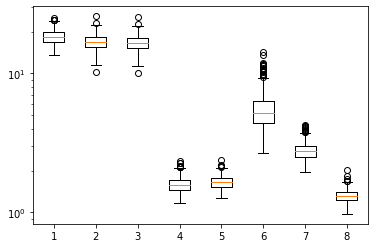

In [49]:
plt.boxplot([ar1, ar2, ar3, ar4, ar5, ar6, ar7, ar8])
plt.yscale("log")

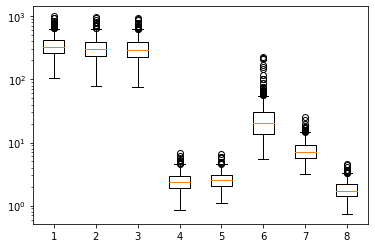

In [50]:
plt.boxplot([ap1, ap2, ap3, ap4, ap5, ap6, ap7, ap8])
plt.yscale("log")

### sigma = 2

In [87]:
sigma = 2

In [88]:
X, y = gauss_sample(n, p, beta_star, Psi, sigma)

In [89]:
D_w = weighted_incidence(cov_est(0.4).fit(X).S)

In [90]:
naive_cv(OUR, X,y, D)

({'l1': 5, 'l2': 2}, 10.339104652404785)

In [91]:
D_w.shape

(119, 121)

In [92]:
def trial1():
    X, y = gauss_sample(n, p, beta_star, Psi, sigma)
    D_w = weighted_incidence(cov_est(0.35).fit(X).S)
    clf1 = OLR().fit(X, y)
    clf2 = LA(l1 = 0).fit(X,y)
    clf3 = EN(l1= 0, l2=0.001).fit(X,y)
    clf4 = FL(1, 3, D).fit(X,y)
    clf5 = SL(0.25, 3, D).fit(X,y)
    clf6 = GTV(0.1, 0.01, 0, D_w).fit(X,y)
    clf7 = GTV(0, 0.5, 0, D_oracle).fit(X,y)
    clf8 = OUR(2, 2, D).fit(X,y)
    return [c.l2_risk(beta_star) for c in [clf1, clf2, clf3, clf4, clf5, clf6, clf7, clf8]]

In [93]:
def trial2():
    X, y = gauss_sample(n, p, beta_star, Psi, sigma)
    D_w = weighted_incidence(cov_est(0.35).fit(X).S)
    clf1 = OLR().fit(X, y)
    clf2 = LA(l1 = 0).fit(X,y)
    clf3 = EN(l1= 0, l2=0.001).fit(X,y)
    clf4 = FL(1, 3, D).fit(X,y)
    clf5 = SL(0.25, 3, D).fit(X,y)
    clf6 = GTV(0.1, 0.01, 0, D_w).fit(X,y)
    clf7 = GTV(0, 0.5, 0, D_oracle).fit(X,y)
    clf8 = OUR(2, 2, D).fit(X,y)
    X2, y2 = gauss_sample(n, p, beta_star, Psi, sigma)
    return [-c.score(X2, X2@beta_star) for c in [clf1, clf2, clf3, clf4, clf5, clf6, clf7, clf8]]

In [94]:
l2s = Parallel(n_jobs=8)(delayed(trial1)() for i in range(500))
preds = Parallel(n_jobs=8)(delayed(trial2)() for i in range(500))

In [95]:
br1 = [l[0] for l in l2s]
br2 = [l[1] for l in l2s]
br3 = [l[2] for l in l2s]
br4 = [l[3] for l in l2s]
br5 = [l[4] for l in l2s]
br6 = [l[5] for l in l2s]
br7 = [l[6] for l in l2s]
br8 = [l[7] for l in l2s]

In [96]:
bp1 = [l[0] for l in preds]
bp2 = [l[1] for l in preds]
bp3 = [l[2] for l in preds]
bp4 = [l[3] for l in preds]
bp5 = [l[4] for l in preds]
bp6 = [l[5] for l in preds]
bp7 = [l[6] for l in preds]
bp8 = [l[7] for l in preds]


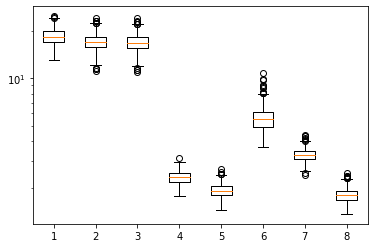

In [97]:
plt.boxplot([br1, br2, br3, br4, br5, br6, br7, br8])
plt.yscale("log")

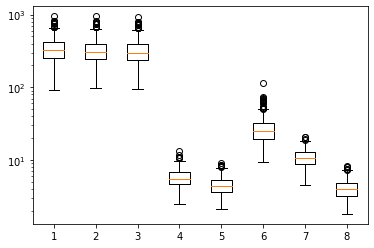

In [98]:
plt.boxplot([bp1, bp2, bp3, bp4, bp5, bp6, bp7, bp8])
plt.yscale("log")

### sigma = 3

In [99]:
sigma = 3

In [103]:
X, y = gauss_sample(n, p, beta_star, Psi, sigma)
naive_cv_cov(X)

({'t': 0.35}, 0.05196690559387207)

In [104]:
D_w = weighted_incidence(cov_est(0.4).fit(X).S)

In [105]:
D_w.shape

(127, 121)

In [106]:
def trial1():
    X, y = gauss_sample(n, p, beta_star, Psi, sigma)
    D_w = weighted_incidence(cov_est(0.35).fit(X).S)
    clf1 = OLR().fit(X, y)
    clf2 = LA(l1 = 0).fit(X,y)
    clf3 = EN(l1= 0, l2=0.001).fit(X,y)
    clf4 = FL(0, 7.5, D).fit(X,y)
    clf5 = SL(0.001, 5, D).fit(X,y)
    clf6 = GTV(5, 0.1, 0, D_w).fit(X,y)
    clf7 = GTV(0, 1, 0, D_oracle).fit(X,y)
    clf8 = OUR(3, 5, D).fit(X,y)
    return [c.l2_risk(beta_star) for c in [clf1, clf2, clf3, clf4, clf5, clf6, clf7, clf8]]

def trial2():
    X, y = gauss_sample(n, p, beta_star, Psi, sigma)
    D_w = weighted_incidence(cov_est(0.35).fit(X).S)
    clf1 = OLR().fit(X, y)
    clf2 = LA(l1 = 0).fit(X,y)
    clf3 = EN(l1= 0, l2=0.001).fit(X,y)
    clf4 = FL(0, 7.5, D).fit(X,y)
    clf5 = SL(0.001, 5, D).fit(X,y)
    clf6 = GTV(5, 0.1, 0, D_w).fit(X,y)
    clf7 = GTV(0, 1, 0, D_oracle).fit(X,y)
    clf8 = OUR(3, 5, D).fit(X,y)
    X2, y2 = gauss_sample(n, p, beta_star, Psi, sigma)
    return [-c.score(X2, X2@beta_star) for c in [clf1, clf2, clf3, clf4, clf5, clf6, clf7, clf8]]

In [107]:
l2s = Parallel(n_jobs=8)(delayed(trial1)() for i in range(500))
preds = Parallel(n_jobs=8)(delayed(trial2)() for i in range(500))

In [108]:
cr1 = [l[0] for l in l2s]
cr2 = [l[1] for l in l2s]
cr3 = [l[2] for l in l2s]
cr4 = [l[3] for l in l2s]
cr5 = [l[4] for l in l2s]
cr6 = [l[5] for l in l2s]
cr7 = [l[6] for l in l2s]
cr8 = [l[7] for l in l2s]

In [109]:
cp1 = [l[0] for l in preds]
cp2 = [l[1] for l in preds]
cp3 = [l[2] for l in preds]
cp4 = [l[3] for l in preds]
cp5 = [l[4] for l in preds]
cp6 = [l[5] for l in preds]
cp7 = [l[6] for l in preds]
cp8 = [l[7] for l in preds]

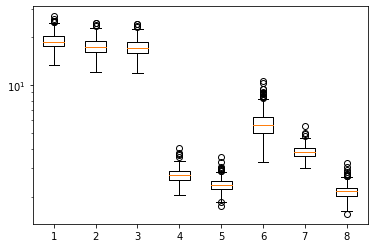

In [110]:
plt.boxplot([cr1, cr2, cr3, cr4, cr5, cr6, cr7, cr8])
plt.yscale("log")

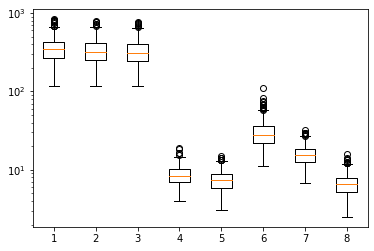

In [111]:
plt.boxplot([cp1, cp2, cp3, cp4, cp5, cp6, cp7, cp8])
plt.yscale("log")

### sigma = 4

In [112]:
sigma = 4

In [124]:
beta_star = beta_star.flatten()

In [127]:
X, y = gauss_sample(n, p, beta_star, Psi, sigma)
naive_cv_cov(X)

({'t': 0.35}, 0.04021000862121582)

In [128]:
naive_cv(OUR, X,y, D)

({'l1': 7.5, 'l2': 7.5}, 11.014692306518555)

In [119]:
D_w = weighted_incidence(cov_est(0.4).fit(X).S)

In [120]:
D_w.shape

(135, 121)

In [129]:
def trial1():
    X, y = gauss_sample(n, p, beta_star, Psi, sigma)
    D_w = weighted_incidence(cov_est(0.35).fit(X).S)
    clf1 = OLR().fit(X, y)
    clf2 = LA(l1 = 0).fit(X,y)
    clf3 = EN(l1= 0, l2=0.001).fit(X,y)
    clf4 = FL(0.5, 10, D).fit(X,y)
    clf5 = SL(0, 10, D).fit(X,y)
    clf6 = GTV(20, 0, 0, D_w).fit(X,y)
    clf7 = GTV(0, 2.5, 0, D_oracle).fit(X,y)
    clf8 = OUR(7.5, 7.5, D).fit(X,y)
    return [c.l2_risk(beta_star) for c in [clf1, clf2, clf3, clf4, clf5, clf6, clf7, clf8]]

def trial2():
    X, y = gauss_sample(n, p, beta_star, Psi, sigma)
    D_w = weighted_incidence(cov_est(0.35).fit(X).S)
    clf1 = OLR().fit(X, y)
    clf2 = LA(l1 = 0).fit(X,y)
    clf3 = EN(l1= 0, l2=0.001).fit(X,y)
    clf4 = FL(0.5, 10, D).fit(X,y)
    clf5 = SL(0, 10, D).fit(X,y)
    clf6 = GTV(20, 0, 0, D_w).fit(X,y)
    clf7 = GTV(0, 2.5, 0, D_oracle).fit(X,y)
    clf8 = OUR(7.5, 7.5, D).fit(X,y)
    X2, y2 = gauss_sample(n, p, beta_star, Psi, sigma)
    return [-c.score(X2, X2@beta_star) for c in [clf1, clf2, clf3, clf4, clf5, clf6, clf7, clf8]]

In [130]:
l2s = Parallel(n_jobs=8)(delayed(trial1)() for i in range(500))
preds = Parallel(n_jobs=8)(delayed(trial2)() for i in range(500))

In [131]:
dr1 = [l[0] for l in l2s]
dr2 = [l[1] for l in l2s]
dr3 = [l[2] for l in l2s]
dr4 = [l[3] for l in l2s]
dr5 = [l[4] for l in l2s]
dr6 = [l[5] for l in l2s]
dr7 = [l[6] for l in l2s]
dr8 = [l[7] for l in l2s]

In [132]:
dp1 = [l[0] for l in preds]
dp2 = [l[1] for l in preds]
dp3 = [l[2] for l in preds]
dp4 = [l[3] for l in preds]
dp5 = [l[4] for l in preds]
dp6 = [l[5] for l in preds]
dp7 = [l[6] for l in preds]
dp8 = [l[7] for l in preds]

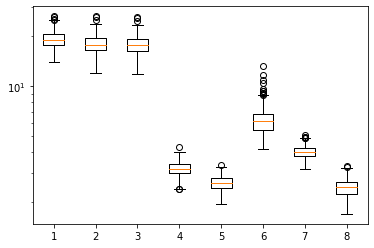

In [133]:
plt.boxplot([dr1, dr2, dr3, dr4, dr5, dr6, dr7, dr8])
plt.yscale("log")

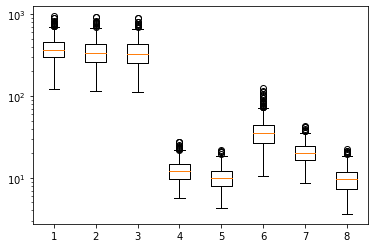

In [134]:
plt.boxplot([dp1, dp2, dp3, dp4, dp5, dp6, dp7, dp8])
plt.yscale("log")

### sigma = 5

In [337]:
sigma = 5

In [214]:
X, y = gauss_sample(n, p, beta_star, Psi, sigma)
naive_cv_cov(X)

({'t': 0.35}, 0.060158491134643555)

In [239]:
naive_cv_large(SL, X,y, D)

({'l1': 1, 'l2': 7.5}, 15.984708786010742)

In [145]:
D_w = weighted_incidence(cov_est(0.35).fit(X).S)

In [146]:
D_w.shape

(169, 121)

In [147]:
def trial1():
    X, y = gauss_sample(n, p, beta_star, Psi, sigma)
    D_w = weighted_incidence(cov_est(0.35).fit(X).S)
    clf1 = OLR().fit(X, y)
    clf2 = LA(l1 = 0).fit(X,y)
    clf3 = EN(l1= 0, l2=0.001).fit(X,y)
    clf4 = FL(0.5, 30, D).fit(X,y)
    clf5 = SL(1, 25, D).fit(X,y)
    clf6 = GTV(30, 2, 0, D_w).fit(X,y)
    clf7 = GTV(0, 2.5, 0, D_oracle).fit(X,y)
    clf8 = OUR(0, 25, D).fit(X,y)
    return [c.l2_risk(beta_star) for c in [clf1, clf2, clf3, clf4, clf5, clf6, clf7, clf8]]

def trial2():
    X, y = gauss_sample(n, p, beta_star, Psi, sigma)
    D_w = weighted_incidence(cov_est(0.35).fit(X).S)
    clf1 = OLR().fit(X, y)
    clf2 = LA(l1 = 0).fit(X,y)
    clf3 = EN(l1= 0, l2=0.001).fit(X,y)
    clf4 = FL(0.5, 30, D).fit(X,y)
    clf5 = SL(1, 25, D).fit(X,y)
    clf6 = GTV(30, 2, 0, D_w).fit(X,y)
    clf7 = GTV(0, 2.5, 0, D_oracle).fit(X,y)
    clf8 = OUR(0, 25, D).fit(X,y)
    X2, y2 = gauss_sample(n, p, beta_star, Psi, sigma)
    return [-c.score(X2, X2@beta_star) for c in [clf1, clf2, clf3, clf4, clf5, clf6, clf7, clf8]]

In [148]:
l2s = Parallel(n_jobs=8)(delayed(trial1)() for i in range(500))
preds = Parallel(n_jobs=8)(delayed(trial2)() for i in range(500))

In [338]:
def triala():
    X, y = gauss_sample(n, p, beta_star, Psi, sigma)
    clf8 = SL(1, 7.5, D).fit(X,y)
    return clf8.l2_risk(beta_star)

In [339]:
er5 = Parallel(n_jobs=8)(delayed(triala)() for i in range(500))

In [248]:
er1 = [l[0] for l in l2s]
er2 = [l[1] for l in l2s]
er3 = [l[2] for l in l2s]
er4 = [l[3] for l in l2s]
er5 = [l[4] for l in l2s]
er6 = [l[5] for l in l2s]
er7 = [l[6] for l in l2s]
#er8 = [l[7] for l in l2s]

In [249]:
ep1 = [l[0] for l in preds]
ep2 = [l[1] for l in preds]
ep3 = [l[2] for l in preds]
ep4 = [l[3] for l in preds]
ep5 = [l[4] for l in preds]
ep6 = [l[5] for l in preds]
ep7 = [l[6] for l in preds]
#ep8 = [l[7] for l in preds]

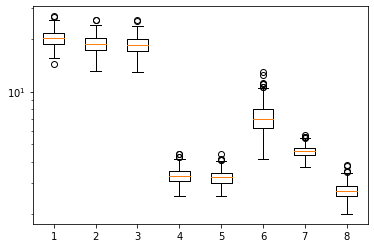

In [340]:
plt.boxplot([er1, er2, er3, er4, er5, er6, er7, er8])
plt.yscale("log")

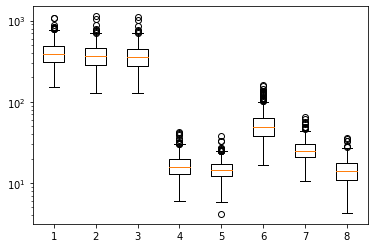

In [317]:
plt.boxplot([ep1, ep2, ep3, ep4, ep5, ep6, ep7, ep8])
plt.yscale("log")

### plots

In [318]:
import matplotlib as mpl
mpl.rcParams['mathtext.fontset'] = 'cm'

In [319]:
LA_risk_med = [np.median(r) for r in [ar1, br1, cr1, dr1, er1]]
LA_risk_err = [[np.median(r) - np.quantile(r, 0.25) for r in [ar1, br1, cr1, dr1, er1]], [np.quantile(r, 0.75) - np.median(r) for r in [ar1, br1, cr1, dr1, er1]]]

In [320]:
EN_risk_med = [np.median(r) for r in [ar3, br3, cr3, dr3, er3]]
EN_risk_err = [[np.median(r) - np.quantile(r, 0.25) for r in [ar3, br3, cr3, dr3, er3]], [np.quantile(r, 0.75) - np.median(r) for r in [ar3, br3, cr3, dr3, er3]]]

In [321]:
FL_risk_med = [np.median(r) for r in [ar4, br4, cr4, dr4, er4]]
FL_risk_err = [[np.median(r) - np.quantile(r, 0.25) for r in [ar4, br4, cr4, dr4, er4]], [np.quantile(r, 0.75) - np.median(r) for r in [ar4, br4, cr4, dr4, er4]]]

In [322]:
SL_risk_med = [np.median(r) for r in [ar5, br5, cr5, dr5, er5]]
SL_risk_err = [[np.median(r) - np.quantile(r, 0.25) for r in [ar5, br5, cr5, dr5, er5]], [np.quantile(r, 0.75) - np.median(r) for r in [ar5, br5, cr5, dr5, er5]]]

In [356]:
GTVEST_risk_med = [np.median(r) for r in [ar6, br6, cr6, dr6, er6]]
GTVEST_risk_err = [[np.median(r) - np.quantile(r, 0.25) for r in [ar6, br6, cr6, dr6, er6]], [np.quantile(r, 0.75) - np.median(r) for r in [ar6, br6, cr6, dr6, er6]]]

In [325]:
GTVORC_risk_med = [np.median(r) for r in [ar7, br7, cr7, dr7, er7]]
GTVORC_risk_err = [[np.median(r) - np.quantile(r, 0.25) for r in [ar7, br7, cr7, dr7, er7]], [np.quantile(r, 0.75) - np.median(r) for r in [ar7, br7, cr7, dr7, er7]]]

In [326]:
GEN_risk_med = [np.median(r) for r in [ar8, br8, cr8, dr8, er8]]
GEN_risk_err = [[np.median(r) - np.quantile(r, 0.25) for r in [ar8, br8, cr8, dr8, er8]], [np.quantile(r, 0.75) - np.median(r) for r in [ar8, br8, cr8, dr8, er8]]]

In [327]:
xs = ["1","2" ,"3" ,"4" ,"5"]

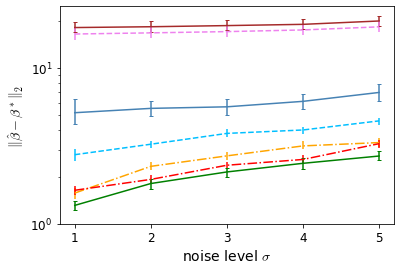

In [328]:
plt.errorbar(xs, LA_risk_med, yerr = LA_risk_err, capsize = 2, color = 'brown', label = "OLS, LASSO")
plt.errorbar(xs, EN_risk_med, yerr = EN_risk_err, fmt = '--', color = 'violet', label = "EN")
plt.errorbar(xs, FL_risk_med, yerr = FL_risk_err, fmt = '-.',color = 'orange', label = "FL")
plt.errorbar(xs, SL_risk_med, yerr = SL_risk_err, fmt = '-.', color = 'red', label = "SL")
plt.errorbar(xs, GTVEST_risk_med, yerr = GTVEST_risk_err, capsize = 2, color = 'steelblue', label = "GTV")
plt.errorbar(xs, GTVORC_risk_med, yerr = GTVORC_risk_err, fmt = '--', color = 'deepskyblue', label = "GTV-oracle", linewidth = 1.5)
plt.errorbar(xs, GEN_risk_med, yerr = GEN_risk_err, capsize = 2, color = 'green', label = "GEN")
plt.yscale("log")
plt.yticks([1, 10], size = 12)
plt.xticks(["1",'2','3','4', '5'], size = 12)
plt.xlabel(r"noise level $\sigma$", size = 14)
plt.ylabel(r'$\| \hat{\beta} - \beta^*\|_2$', size = 14)
plt.savefig('144a_v2.jpg', bbox_inches='tight', dpi = 600)

In [329]:
LA_pred_med = [np.median(r) for r in [ap1, bp1, cp1, dp1, ep1]]
LA_pred_err = [[np.median(r) - np.quantile(r, 0.25) for r in [ap1, bp1, cp1, dp1, ep1]], [np.quantile(r, 0.75) - np.median(r) for r in [ap1, bp1, cp1, dp1, ep1]]]

In [377]:
GEN_pred_err

[[0.30545596374643025,
  0.7655071201107844,
  1.3255381662265942,
  2.154449560015718,
  2.896492514589262],
 [0.4525812843282657,
  0.846294734769419,
  1.2986098120814642,
  2.3538045835576327,
  3.639183027332683]]

In [330]:
EN_pred_med = [np.median(r) for r in [ap3, bp3, cp3, dp3, ep3]]
EN_pred_err = [[np.median(r) - np.quantile(r, 0.25) for r in [ap3, bp3, cp3, dp3, ep3]], [np.quantile(r, 0.75) - np.median(r) for r in [ap3, bp3, cp3, dp3, ep3]]]

In [331]:
FL_pred_med = [np.median(r) for r in [ap4, bp4, cp4, dp4, ep4]]
FL_pred_err = [[np.median(r) - np.quantile(r, 0.25) for r in [ap4, bp4, cp4, dp4, ep4]], [np.quantile(r, 0.75) - np.median(r) for r in [ap4, bp4, cp4, dp4, ep4]]]

In [332]:
SL_pred_med = [np.median(r) for r in [ap5, bp5, cp5, dp5, ep5]]
SL_pred_err = [[np.median(r) - np.quantile(r, 0.25) for r in [ap5, bp5, cp5, dp5, ep5]], [np.quantile(r, 0.75) - np.median(r) for r in [ap5, bp5, cp5, dp5, ep5]]]

In [378]:
GTVEST_pred_med = [np.median(r) for r in [ap6, bp6, cp6, dp6, ep6]]
GTVEST_pred_err = [[np.median(r) - np.quantile(r, 0.25) for r in [ap6, bp6, cp6, dp6, ep6]], [np.quantile(r, 0.75) - np.median(r) for r in [ap6, bp6, cp6, dp6, ep6]]]

In [381]:
GTVEST_pred_err

[[2.7800011446699813,
  5.768624136043119,
  5.737499925464405,
  8.297720948291328,
  11.267825059618602],
 [4.223335231681634,
  6.744947742736944,
  8.84116319642601,
  9.662572452352052,
  13.914674304348033]]

In [334]:
GTVORC_pred_med = [np.median(r) for r in [ap7, bp7, cp7, dp7, ep7]]
GTVORC_pred_err = [[np.median(r) - np.quantile(r, 0.25) for r in [ap7, bp7, cp7, dp7, ep7]], [np.quantile(r, 0.75) - np.median(r) for r in [ap7, bp7, cp7, dp7, ep7]]]

In [335]:
GEN_pred_med = [np.median(r) for r in [ap8, bp8, cp8, dp8, ep8]]
GEN_pred_err = [[np.median(r) - np.quantile(r, 0.25) for r in [ap8, bp8, cp8, dp8, ep8]], [np.quantile(r, 0.75) - np.median(r) for r in [ap8, bp8, cp8, dp8, ep8]]]

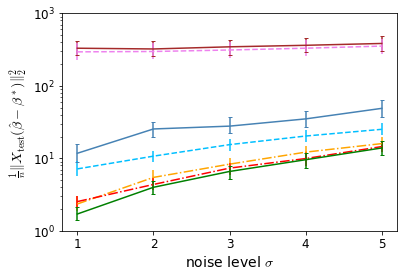

In [379]:
plt.errorbar(xs, LA_pred_med, yerr = LA_pred_err, capsize = 2, color = 'brown', label = "OLS, LASSO")
plt.errorbar(xs, EN_pred_med, yerr = EN_pred_err, fmt = '--',color = 'violet', label = "EN")
plt.errorbar(xs, FL_pred_med, yerr = FL_pred_err, fmt = '-.',color = 'orange', label = "FL")
plt.errorbar(xs, SL_pred_med, yerr = SL_pred_err, fmt = '-.', color = 'red', label = "SL")
plt.errorbar(xs, GTVEST_pred_med, yerr = GTVEST_pred_err, capsize = 2, color = 'steelblue', label = "GTV")
plt.errorbar(xs, GTVORC_pred_med, yerr = GTVORC_pred_err, fmt = '--', color = 'deepskyblue', label = "GTV-oracle", linewidth = 1.5)
plt.errorbar(xs, GEN_pred_med, yerr = GEN_pred_err, capsize = 2, color = 'green', label = "GEN")
plt.yscale("log")

plt.yticks([1, 10, 100, 1000], size = 12)
plt.xticks(["1",'2','3','4', '5'], size = 12)
plt.xlabel(r"noise level $\sigma$", size = 14)
plt.ylabel(r'$\frac{1}{n}\| X_{\mathrm{test}}(\hat{\beta} - \beta^*)\|_2^2$', size = 14)
plt.savefig('144b_v2.jpg', bbox_inches='tight', dpi = 600)